In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

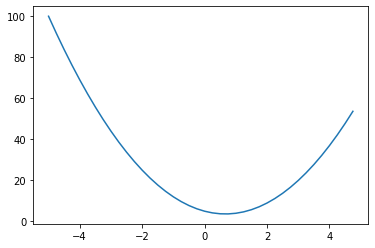

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [57]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        # print(f"x is {x}")
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, k):
        x = self.data
        out = Value(x**k, (self, ), f'**{k}')

        def _backward():
            self.grad += k * x**(k-1) * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        
        build_topo(self)
        for node in reversed(topo):
            node._backward()
            


In [6]:
v = Value(2.0)
2 * v

Value(data=4.0, label=)

In [7]:
v1 = v.exp()
v1

Value(data=7.38905609893065, label=)

In [8]:
v2 = v**3

In [9]:
v2 / v

Value(data=4.0, label=)

In [10]:
v2 - v

Value(data=6.0, label=)

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0, label=L)

In [12]:
 d._prev

{Value(data=-6.0, label=e), Value(data=10, label=c)}

In [13]:
d._op

'+'

In [14]:
# !pip install graphviz

In [15]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [16]:
trace(L)

({Value(data=-2.0, label=f),
  Value(data=-3.0, label=b),
  Value(data=-6.0, label=e),
  Value(data=-8.0, label=L),
  Value(data=10, label=c),
  Value(data=2.0, label=a),
  Value(data=4.0, label=d)},
 {(Value(data=-2.0, label=f), Value(data=-8.0, label=L)),
  (Value(data=-3.0, label=b), Value(data=-6.0, label=e)),
  (Value(data=-6.0, label=e), Value(data=4.0, label=d)),
  (Value(data=10, label=c), Value(data=4.0, label=d)),
  (Value(data=2.0, label=a), Value(data=-6.0, label=e)),
  (Value(data=4.0, label=d), Value(data=-8.0, label=L))})

In [17]:
str(id(a))

'140492048720080'

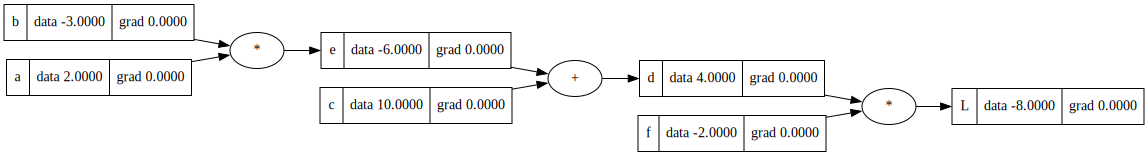

In [18]:
draw_dot(L)

In [19]:
def lol():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'

    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L' 


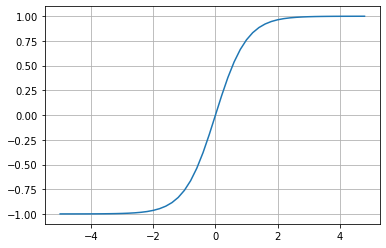

In [20]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [21]:
v = Value(2)
v.tanh()

Value(data=0.36114149417235686, label=)

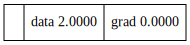

In [22]:
draw_dot(v)

In [23]:
build_topo(L)
topo

NameError: name 'build_topo' is not defined

In [ ]:
L.grad = 1
for node in reversed(topo):
    node._backward()

In [ ]:
draw_dot(L)

In [ ]:
a = Value(3.0, label='a')
b = a + a
b.backward()
# a.backward()
draw_dot(b)

In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

output = w1*x1 + w2*x2 + b
o = torch.tanh(output)
print(o)

o.backward()
print(w1.grad.item())

In [67]:
import random
random.uniform(-1, 1)
??random.uniform

Signature: random.uniform(a, b)
Source:   
    def uniform(self, a, b):
        "Get a random number in the range [a, b) or [a, b] depending on rounding."
        return a + (b - a) * self.random()
File:      /opt/anaconda3/lib/python3.9/random.py
Type:      method


In [68]:
import numpy as np

In [69]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return [self.b] + self.w

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nout):
        layer_dims = [nin] + nout
        self.layers = [Layer(layer_dims[i], layer_dims[i+1]) for i in range(len(nout))]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [70]:
x = [1, 2, 3]
mlp1 = MLP(len(x), [3, 3, 1])
mlp1(x)

Value(data=-0.9437216387003834, label=)

In [71]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [83]:
lr = 0.1

for i in range(200):
    # fwd pass
    ypred = [mlp1(x) for x in xs]
    loss = sum((y_h - yi)**2 for y_h, yi in zip(ypred, ys))
    # zero grad
    for p in mlp1.parameters():
        p.grad = 0
    # backward
    loss.backward()
    # update params
    for p in mlp1.parameters():
        # print(f"grad is {p.grad}")
        p.data += -lr * p.grad
    
    print(i, loss.data)

0 0.0016354610509373524
1 0.0016248214833119179
2 0.001614228785395967
3 0.0016047587223764618
4 0.0015944544561142474
5 0.001585112014053599
6 0.0015750061525211692
7 0.001565865176038662
8 0.001556017563485734
9 0.0015464042374064948
10 0.0015368611993488842
11 0.0015281449089078933
12 0.0015194357833536204
13 0.0015108989717602147
14 0.0015018878950459824
15 0.0014929602792159665
16 0.0014840957792298785
17 0.0014754624582867556
18 0.0014668686832351148
19 0.00145893582430377
20 0.001451141980036006
21 0.0014427292515976416
22 0.0014344241182450502
23 0.0014267368478743617
24 0.0014193048419467724
25 0.0014118117995832518
26 0.0014039925830698417
27 0.0013966496869941615
28 0.001388851186719559
29 0.0013812257757926643
30 0.0013741413110108975
31 0.0013666878405422722
32 0.0013594000610583313
33 0.001352078970692099
34 0.0013447884087034226
35 0.0013381621491145113
36 0.0013315716562252505
37 0.0013245529958194036
38 0.0013175969601554754
39 0.0013107344923489433
40 0.00130444482537

In [84]:
ypred

[Value(data=0.9847738472472963, label=),
 Value(data=-0.9878616812807567, label=),
 Value(data=-0.9916081751890476, label=),
 Value(data=0.9834845819002358, label=)]